### Данный проект направлен на изучение эффективности индикаторов технического анализа при торговле на фондовом рынке, анализа данных и не несет в себе инвестиционных рекомендаций.

#### В этом модуле торговая стратегия будет усложнена: добавлены дополнительные условия. Сигнал к покупке акции будет приниматься при выполнении следующих условий:
- бычий тренд (согласно 200-й экспоненциальной скользящей средней)
- пересечение MACD сигнальной линии снизу вверх ниже нулевой отметки

Также добавлена возможность анализа исторических данных на разных временных торговых интервалах (таймфреймах)

In [288]:
import yfinance as yf
from datetime import date, timedelta, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (15, 10)})

In [289]:
# назначим переменную с сегодняшней датой
today = date.today().strftime("%Y-%m-%d") # текущая дата

# Устанавливаем вводные данные для выгрузки
stock = 'AMD' # тикер акции
date_from = '2020-08-25' # дата, с которой планируем собрать данные
date_to = today # дата, по которую необходимы данные
interval = '1h' # таймфрейм [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
currency = 'USD' # валюта

strategy_date_from = date_from # Дата, с которой будем анализировать стратегию

In [290]:
data = yf.download(stock,
                      start = date_from,
                      end = date_to,
                      interval = interval)

[*********************100%***********************]  1 of 1 completed


In [291]:
# Для удобства убираем в названии колонок буквы верхнего регистра и заменяем пробелы на нижнее подчеркивание
data.columns = [column.lower() for column in data.columns]
data.columns = [column.replace(' ', '_') for column in data.columns]

In [292]:
# Округляем значения в датафрейме
data = round(data, 2)

In [293]:
data.head()

,open,high,low,close,adj_close,volume
2020-08-25 09:30:00-04:00,83.18,83.81,82.35,83.55,83.55,9449677
2020-08-25 10:30:00-04:00,83.55,84.92,83.39,84.64,84.64,7334524
2020-08-25 11:30:00-04:00,84.65,84.87,83.96,84.67,84.67,5937990
2020-08-25 12:30:00-04:00,84.68,85.75,84.66,85.61,85.61,7531952
2020-08-25 13:30:00-04:00,85.60,85.66,85.11,85.32,85.32,4558395


<AxesSubplot:>

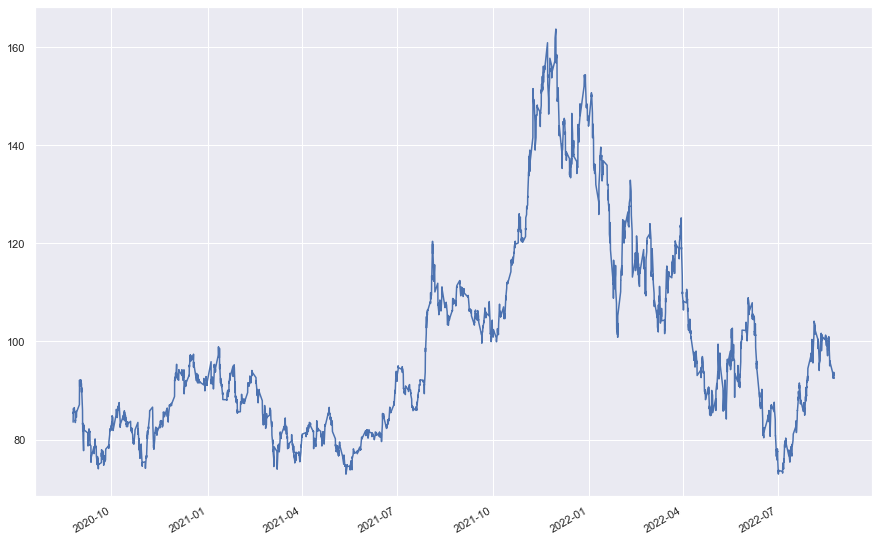

In [294]:
# Посмотрим график изменения цены акции за выбранный период
data.close.plot()

In [295]:
# Функции расчетов скользящих средних 
# SMA простая скользящая средняя
# EMA экспоненциальная скользящая средняя

def SMA(data, ndays): 
     SMA = pd.Series(data['close'].rolling(ndays).mean().round(4), name = 'SMA' + str(ndays))  
     return SMA

# Exponentially-weighted Moving Average 
def EWMA(data, ndays): 
     EMA = pd.Series(data['close'].ewm(span = ndays, min_periods = ndays - 1).mean().round(4), 
                 name = 'EWMA_' + str(ndays))
     return EMA

In [296]:
# Считаем динамику изменения цены акции по дням и изменение в процентном соотношении
data['range'] = data.high - data.low
data['score'] = ((data.close - data.open)/data.open).mul(100).round(2)

In [297]:
# Рассчитываем простые и экспоненциальные скользящие средние, необходимые в рамках стратегии

data['ema200'] = EWMA(data,200)
data['ema12'] = EWMA(data,12)
data['ema26'] = EWMA(data,26)

In [298]:
# В стратегии MACD мы используем две линии: линия MACD - Схождение/расхождение скользящих средних,
# которая представляет собой разницу между 26-дневной EMA и 12-дневной EMA, и сигнальную линию,
# которая является 9-дневной EMA линии MACD

# Calculate MACD
data['macd'] = data['ema12']- data['ema26'] 

# Calculate Signal
data['macdsignal'] = data.macd.ewm(span=9, adjust=False).mean()

In [299]:
# Создание торгового сигнала
# Стратегия подразумевает покупку при бычьем тренде (цена акции выше 200 EMA) и пересечении MACD ниже нулевой отметки

conditions = [
    (data['macd'] > data['macdsignal']) & (data['macd'] < 0) & (data['open'] > data['ema200']),
     (data['macd'] < data['macdsignal']) & (data['macd'] > 0) & (data['open'] < data['ema200'])
            ]
choices = ['buy', 'sell']
data['strategy_signal'] = np.select(conditions, choices, default = 'no_signal')

# Создание торгового сигнала при каждом пересечении MACD без дополнительных условий
data['cross_macd'] = np.where(data['macd'] > data['macdsignal'], 'buy', 'sell')

In [300]:
data = data.dropna()

In [301]:
data.tail()

,open,high,low,close,adj_close,volume,range,score,ema200,ema12,ema26,macd,macdsignal,strategy_signal,cross_macd
2022-08-23 12:30:00-04:00,93.08,93.65,92.94,93.30,93.30,4951133,0.71,0.24,94.3545,93.7910,95.2699,-1.4789,-1.492993,no_signal,buy
2022-08-23 13:30:00-04:00,93.31,93.64,92.90,93.50,93.50,4261476,0.74,0.20,94.3460,93.7463,95.1388,-1.3925,-1.472894,no_signal,buy
2022-08-23 14:30:00-04:00,93.50,93.52,93.04,93.14,93.14,4900234,0.48,-0.39,94.3340,93.6530,94.9907,-1.3377,-1.445855,no_signal,buy
2022-08-23 15:30:00-04:00,93.15,93.17,92.42,92.48,92.48,4645988,0.75,-0.72,94.3155,93.4725,94.8048,-1.3323,-1.423144,no_signal,buy
2022-08-23 16:00:00-04:00,92.49,92.49,92.49,92.49,92.49,0,0.00,0.00,94.2974,93.3214,94.6333,-1.3119,-1.400895,no_signal,buy


In [302]:
data = data.reset_index()
data = data.rename(columns = {data.columns[0] : 'Datetime'})

In [303]:
# Преобразуем колонку 'strategy_signal' таким образом, чтобы сигналы к покупке и продаже были актуальны только при первом выполнении условий,
# то есть как только сигнал сработал, мы сразу совершаем сделку
# уберем дубликаты, которые встречаются следом за датой нашей сделки

new_strategy_signal_list = list(data.strategy_signal) # дублируем список сигналов по стратегии, в нем будем вносить изменения
      
for index in range(1, len(new_strategy_signal_list)):
    
    if new_strategy_signal_list[-index] == new_strategy_signal_list[-index - 1] == 'buy':
        new_strategy_signal_list[-index] = 'no_signal'
    elif new_strategy_signal_list[-index] == new_strategy_signal_list[-index - 1] == 'sell':
        new_strategy_signal_list[-index] = 'no_signal'

data['strategy_signal'] = new_strategy_signal_list      

In [304]:
data

,Datetime,open,high,low,close,adj_close,volume,range,score,ema200,ema12,ema26,macd,macdsignal,strategy_signal,cross_macd
0,2020-10-05 11:30:00-04:00,84.96,85.89,84.75,85.73,85.73,6827269,1.14,0.91,80.3766,83.7492,82.8760,0.8732,0.852218,no_signal,buy
1,2020-10-05 12:30:00-04:00,85.72,85.87,85.42,85.71,85.71,4201796,0.45,-0.01,80.4379,84.0509,83.0860,0.9649,0.874754,no_signal,buy
2,2020-10-05 13:30:00-04:00,85.71,85.72,85.12,85.54,85.54,4521439,0.60,-0.20,80.4966,84.2800,83.2677,1.0123,0.902264,no_signal,buy
3,2020-10-05 14:30:00-04:00,85.54,86.28,85.54,86.14,86.14,6116790,0.74,0.70,80.5613,84.5661,83.4805,1.0856,0.938931,no_signal,buy
4,2020-10-05 15:30:00-04:00,86.13,86.27,85.92,86.13,86.13,3704323,0.35,0.00,80.6251,84.8067,83.6768,1.1299,0.977125,no_signal,buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3310,2022-08-23 12:30:00-04:00,93.08,93.65,92.94,93.30,93.30,4951133,0.71,0.24,94.3545,93.7910,95.2699,-1.4789,-1.492993,no_signal,buy
3311,2022-08-23 13:30:00-04:00,93.31,93.64,92.90,93.50,93.50,4261476,0.74,0.20,94.3460,93.7463,95.1388,-1.3925,-1.472894,no_signal,buy
3312,2022-08-23 14:30:00-04:00,93.50,93.52,93.04,93.14,93.14,4900234,0.48,-0.39,94.3340,93.6530,94.9907,-1.3377,-1.445855,no_signal,buy
3313,2022-08-23 15:30:00-04:00,93.15,93.17,92.42,92.48,92.48,4645988,0.75,-0.72,94.3155,93.4725,94.8048,-1.3323,-1.423144,no_signal,buy


In [305]:
# Создаем датафрейм. Дата и время покупки согласно стратегии, а также цена покупки
buy_dates_data = data[data.strategy_signal == 'buy'][['Datetime', 'open']]
buy_dates_data = buy_dates_data.rename(columns = {'Datetime':'buy_date',
                                 'open': 'buy_price'})
buy_dates_data.head()

,buy_date,buy_price
39,2020-10-12 15:30:00-04:00,84.04
47,2020-10-14 09:30:00-04:00,85.86
66,2020-10-16 14:30:00-04:00,83.18
192,2020-11-11 14:30:00-05:00,80.88
330,2020-12-10 15:30:00-05:00,91.48


In [306]:
# Теперь нам известны даты сделок по покупке
# Далее будем искать сигналы для продажи
# Сделаем это по индексам строк: так как условия для покупки были особенные, сигналы искали в колонке 'strategy_signal',
# для продажи будем искать ближайщее пересечение MACD сигнальной линии в обратном направлении в колонке 'cross_macd'

# создаем список, в который добавим индексы строк из общего датафрейма, содержащих инфо о дате и времени продажи
sell_dates_indexes = [] 
for index in list(buy_dates_data.index):
    
    if data.cross_macd[index] != 'sell':
        if index != buy_dates_data.index[-1]:
            index += 1
    sell_dates_indexes.append(index)


In [307]:
buy_dates_data.index

Int64Index([  39,   47,   66,  192,  330,  391,  412,  447,  917,  946, 1191,
            1224, 1332, 1378, 1383, 1492, 1539, 1612, 1636, 1641, 1652, 1670,
            1890, 2009, 2061, 2077, 2187, 3175, 3247, 3288, 3293],
           dtype='int64')

In [308]:
# Создаем датафрейм. Дата и время продажи согласно стратегии, а также цена покупки
sell_dates_data = data.loc[sell_dates_indexes][['Datetime', 'open']]
sell_dates_data = sell_dates_data.rename(columns = {'Datetime':'sell_date',
                                 'open': 'sell_price'})


In [309]:
# Объединяем оба датайрейма, теперь видими даты покупки и продажи акции, а также цены
join_data = pd.concat([buy_dates_data.reset_index(drop = True), sell_dates_data.reset_index(drop = True)],axis=1)

In [310]:
join_data.head()

,buy_date,buy_price,sell_date,sell_price
0,2020-10-12 15:30:00-04:00,84.04,2020-10-13 09:30:00-04:00,84.86
1,2020-10-14 09:30:00-04:00,85.86,2020-10-14 10:30:00-04:00,83.87
2,2020-10-16 14:30:00-04:00,83.18,2020-10-16 15:30:00-04:00,83.62
3,2020-11-11 14:30:00-05:00,80.88,2020-11-11 15:30:00-05:00,81.32
4,2020-12-10 15:30:00-05:00,91.48,2020-12-11 09:30:00-05:00,91.54


In [311]:
# Добавим колонки со значением финансового результата совершенных сделок
join_data['result'] = join_data['sell_price'] - join_data['buy_price']
join_data['percent'] = round((join_data['result'] / join_data['buy_price']).mul(100), 2)
join_data['profit'] = join_data['result'] > 0

In [312]:
join_data

,buy_date,buy_price,sell_date,sell_price,result,percent,profit
0,2020-10-12 15:30:00-04:00,84.04,2020-10-13 09:30:00-04:00,84.86,0.82,0.98,True
1,2020-10-14 09:30:00-04:00,85.86,2020-10-14 10:30:00-04:00,83.87,-1.99,-2.32,False
2,2020-10-16 14:30:00-04:00,83.18,2020-10-16 15:30:00-04:00,83.62,0.44,0.53,True
3,2020-11-11 14:30:00-05:00,80.88,2020-11-11 15:30:00-05:00,81.32,0.44,0.54,True
4,2020-12-10 15:30:00-05:00,91.48,2020-12-11 09:30:00-05:00,91.54,0.06,0.07,True
5,2020-12-23 13:30:00-05:00,92.20,2020-12-23 14:30:00-05:00,92.33,0.13,0.14,True
6,2020-12-30 09:30:00-05:00,90.78,2020-12-30 10:30:00-05:00,91.57,0.79,0.87,True
7,2021-01-07 09:30:00-05:00,91.33,2021-01-07 10:30:00-05:00,93.79,2.46,2.69,True
8,2021-04-15 10:30:00-04:00,81.19,2021-04-15 11:30:00-04:00,81.87,0.68,0.84,True
9,2021-04-21 11:30:00-04:00,81.33,2021-04-21 12:30:00-04:00,81.10,-0.23,-0.28,False


In [313]:
join_data.percent.describe()

count    31.000000
mean      0.344194
std       1.178648
min      -2.320000
25%      -0.150000
50%       0.200000
75%       0.765000
max       3.580000
Name: percent, dtype: float64

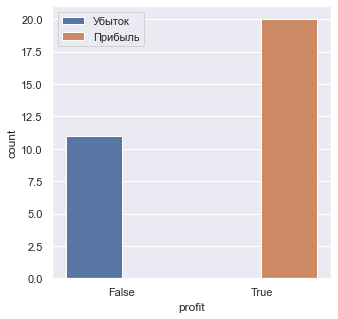

In [314]:
# Посмотрим статистику прибыльных и убыточных сделок
fig = plt.figure(figsize=(5, 5))
ax = sns.countplot(x="profit", hue="profit", data=join_data)
plt.legend(labels=['Убыток', 'Прибыль'])

Text(0.5, 8.95999999999998, 'Прибыль/убычток в %')

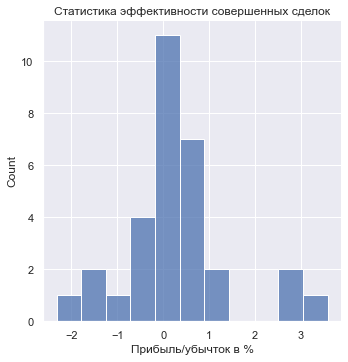

In [315]:
# Посмотрим график распределения прибыльности/убыточности сделок
ax = sns.displot(join_data.percent)
plt.title('Статистика эффективности совершенных сделок')
plt.xlabel('Прибыль/убычток в %')

#### Проведем анализ динамики изменения капитала при условии алгоритмической торговли по данной стратегии

Для удобства расчетов экономической эффективности возьмем стоимость одной акции на момент первой сделки за стартовый капитал. Опустим ситуацию, при которой убыточные сделки могут привести к нехватке средств на депозите для осуществления следующей покупки. Иными словами первая сделка осуществляется на 100% депозита


In [316]:
start_deposit = join_data.buy_price[0] # стартовый капитал согласно условиям
deposit_history = [start_deposit] # создадим список с данными об изменении капитала после совершения каждой сделки

deposit = start_deposit
for result in join_data.result:
    deposit += result
    deposit_history.append(round(deposit, 2))

In [317]:
# добавим в таблицу колонку с данными о депозите по состоянию на даты совершения сделок
join_data['deposit'] = pd.Series(deposit_history[1:])

In [318]:
join_data

,buy_date,buy_price,sell_date,sell_price,result,percent,profit,deposit
0,2020-10-12 15:30:00-04:00,84.04,2020-10-13 09:30:00-04:00,84.86,0.82,0.98,True,84.86
1,2020-10-14 09:30:00-04:00,85.86,2020-10-14 10:30:00-04:00,83.87,-1.99,-2.32,False,82.87
2,2020-10-16 14:30:00-04:00,83.18,2020-10-16 15:30:00-04:00,83.62,0.44,0.53,True,83.31
3,2020-11-11 14:30:00-05:00,80.88,2020-11-11 15:30:00-05:00,81.32,0.44,0.54,True,83.75
4,2020-12-10 15:30:00-05:00,91.48,2020-12-11 09:30:00-05:00,91.54,0.06,0.07,True,83.81
5,2020-12-23 13:30:00-05:00,92.20,2020-12-23 14:30:00-05:00,92.33,0.13,0.14,True,83.94
6,2020-12-30 09:30:00-05:00,90.78,2020-12-30 10:30:00-05:00,91.57,0.79,0.87,True,84.73
7,2021-01-07 09:30:00-05:00,91.33,2021-01-07 10:30:00-05:00,93.79,2.46,2.69,True,87.19
8,2021-04-15 10:30:00-04:00,81.19,2021-04-15 11:30:00-04:00,81.87,0.68,0.84,True,87.87
9,2021-04-21 11:30:00-04:00,81.33,2021-04-21 12:30:00-04:00,81.10,-0.23,-0.28,False,87.64


In [319]:
# Для построения графика изменения депозита нам необходимы списки с датами сделок, включая дату первой покупки
# для этого добавим первый элемент (index первой покупки) в список

plot_dates_indexes = sell_dates_indexes # добавим в список индекс даты первой покупки для отображения на графике
plot_dates_indexes.insert(0, buy_dates_data.index[0])

In [320]:
plot_df = data.loc[plot_dates_indexes][['Datetime', 'open']]
plot_df['deposit'] = deposit_history
plot_df = plot_df.rename(columns = {'open': 'price'})

In [321]:
plot_df = plot_df.set_index('Datetime')

In [322]:
plot_df.head(5)

,price,deposit
Datetime,,
2020-10-12 15:30:00-04:00,84.04,84.04
2020-10-13 09:30:00-04:00,84.86,84.86
2020-10-14 10:30:00-04:00,83.87,82.87
2020-10-16 15:30:00-04:00,83.62,83.31
2020-11-11 15:30:00-05:00,81.32,83.75


#### Посмотрим на графике динамику изменения капитала в пределах срока осуществления сделок (от первой покупки до момента закрытия последней сделки)

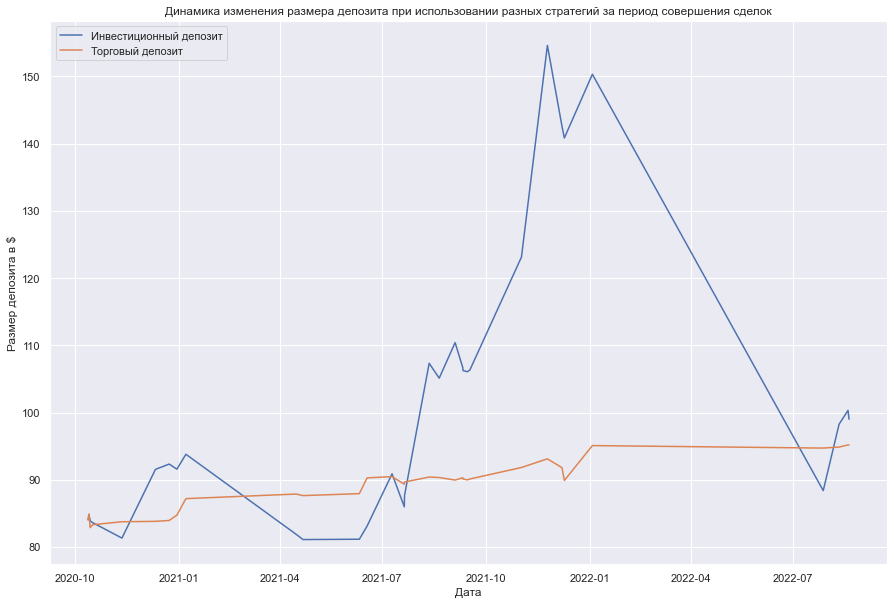

In [323]:
ax = sns.lineplot(data = plot_df.price)
ax = sns.lineplot(data = plot_df.deposit)
ax.set_title('Динамика изменения размера депозита при использовании разных стратегий за период совершения сделок')
ax.set_xlabel('Дата')
ax.set_ylabel('Размер депозита в $')
plt.legend(loc='upper left', labels=['Инвестиционный депозит', 'Торговый депозит'])

#### Для оценки эффективности стратегии недостаточно добиться положительного финансового результата (прибыли), необходимо обратить внимание на динамику рынка за выбранный период. Посчитаем финансовый результат в случае, если бы мы просто купили акцию и держали в течение всего выбранного периода, после чего сравним с результатами торговли согласно стратегии.

## Результаты

In [324]:
years = (data.iloc[-1][0] - data.iloc[0][0]) # вычислим период в годах, в течение которого применяли нашу стратегию
years = years.days / 365

In [325]:
print('Анализируемый период с {} по {}'.format(datetime.strptime(date_from, '%Y-%m-%d').strftime('%d/%m/%Y'), date.today().strftime('%d/%m/%Y')))
print('Рассматриваемый временной интервал (таймфрейм): {}'.format(interval))
print('-----------------------------------')

print('Всего за указанный период было совершено {} сделок, из которых:'.format(len(join_data)) )
print('Прибыльных: {}, что составляет {} %' \
      .format(len(join_data[join_data.profit == True]), round((len(join_data[join_data.profit == True]) / len(join_data)) * 100, 1)   ))
print('Убыточных: {}, что составляет {} %' \
      .format(len(join_data[join_data.profit == False]), round((len(join_data[join_data.profit == False]) / len(join_data)) * 100, 1)   ))
print('Максимальная прибыль одной сделки {} %'.format( round(join_data.percent.max(), 1)   ))
print('Максимальный убыток одной сделки {} %'.format( round(join_data.percent.min(), 1)   ))

print('-----------------------------------')

print('За указанный период цена акции {} изменилась с {} до {} {} - ровно так же изменился размер депозита в случае инвестиции' \
      .format(stock, data.open[0], data.close.iloc[-1], currency))

print('Изменение депозита в таком случае для одной акции составило {} %' \
     .format(round((data.close.iloc[-1] / data.open[0]) *100 - 100, 2)))

print('Чистая прибыль/убыток на одну акцию: {} {}' \
      .format(round(data.close.iloc[-1] - data.open[0], 2), currency))
print('Прибыльность/убыточность инвестиционной стратегии: {} % годовых' \
      .format(round((data.close.iloc[-1] / data.open[0] *100 - 100) / years, 2)))

print('-----------------------------------')

print('Депозит при торговой стратегии изменился с {} до {} {}' \
      .format(deposit_history[0], round(deposit, 2), currency))
print('Изменение депозита при торговой стратегии для одной акции составило {} %' \
      .format(round((deposit - join_data.buy_price[0]) / join_data.buy_price[0] * 100, 2)))

print('Чистая прибыль/убыток на одну акцию: {} {}' \
      .format( round(deposit - join_data.buy_price[0], 2), currency) )
print('Прибыльность/убыточность торговой стратегии: {} % годовых' \
      .format(round((deposit / join_data.buy_price[0] * 100 - 100) / years, 2)))

print('-----------------------------------')

if round((data.close.iloc[-1] / data.open[0] *100 - 100) / years, 2) > round((deposit / join_data.buy_price[0] * 100 - 100) / years, 2):
    print('За указанный период инвестиционная стратегия оказалась эффективнее')
else:
    print('За указанный период торговая стратегия оказалась эффективнее')

Анализируемый период с 25/08/2020 по 24/08/2022
Рассматриваемый временной интервал (таймфрейм): 1h
-----------------------------------
Всего за указанный период было совершено 31 сделок, из которых:
Прибыльных: 20, что составляет 64.5 %
Убыточных: 11, что составляет 35.5 %
Максимальная прибыль одной сделки 3.6 %
Максимальный убыток одной сделки -2.3 %
-----------------------------------
За указанный период цена акции AMD изменилась с 84.96 до 92.49 USD - ровно так же изменился размер депозита в случае инвестиции
Изменение депозита в таком случае для одной акции составило 8.86 %
Чистая прибыль/убыток на одну акцию: 7.53 USD
Прибыльность/убыточность инвестиционной стратегии: 4.71 % годовых
-----------------------------------
Депозит при торговой стратегии изменился с 84.04 до 95.18 USD
Изменение депозита при торговой стратегии для одной акции составило 13.26 %
Чистая прибыль/убыток на одну акцию: 11.14 USD
Прибыльность/убыточность торговой стратегии: 7.04 % годовых
----------------------